In [1]:
import os
import time
import copy
import random
import numpy as np
import pandas as pd

import cv2
import glob
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from torch.utils.data import Dataset, DataLoader

In [2]:
cd drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


## Hyper-parameter settings

In [3]:
num_epochs = 10
learning_rate = 5e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Define CustomDataset

In [4]:
class CustomDataset(Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])

        img = Image.open(img_path).convert("RGB")

        mask = Image.open(mask_path)
        mask =np.array(mask)

        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]

        masks = mask == obj_ids[:, None, None]

        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target
    
    def __len__(self):
        return len(self.imgs)

## Define Model

In [5]:
def get_instance_segmentation_model(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

    return model

## Make DataLoader

In [6]:
# 

from engine import train_one_epoch, evaluate
import utils
import transforms as T

def get_transform(train):
    transform = []
    transform.append(T.ToTensor())
    if train:
        transform.append(T.RandomHorizontalFlip(0.5))
    
    return T.Compose(transform)

In [7]:
train_dataset = CustomDataset('./data/PennFudanPed', get_transform(train=True))
test_dataset = CustomDataset('./data/PennFudanPed', get_transform(train=False))

indices = torch.randperm(len(train_dataset)).tolist()
train_dataset = torch.utils.data.Subset(train_dataset, indices[:-50])
test_dataset = torch.utils.data.Subset(test_dataset, indices[-50:])

train_dataloader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=utils.collate_fn
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Train

In [8]:
num_classes = 2

model = get_instance_segmentation_model(num_classes).to(device)
params = [p for p in model.parameters() if p.requires_grad]
# optimizer = optim.AdamW(params, lr=learning_rate, weight_decay=5e-4)
optimizer = optim.SGD(params, lr=learning_rate, momentum=0.9, weight_decay=5e-4)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [9]:
model.train()
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_dataloader, device, epoch, print_freq=10)

    lr_scheduler.step()

    evaluate(model, test_dataloader, device=device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [ 0/60]  eta: 0:01:41  lr: 0.000090  loss: 4.8431 (4.8431)  loss_classifier: 0.9812 (0.9812)  loss_box_reg: 0.2616 (0.2616)  loss_mask: 3.5653 (3.5653)  loss_objectness: 0.0294 (0.0294)  loss_rpn_box_reg: 0.0057 (0.0057)  time: 1.6875  data: 0.3803  max mem: 1856
Epoch: [0]  [10/60]  eta: 0:01:17  lr: 0.000936  loss: 1.6371 (2.2667)  loss_classifier: 0.5221 (0.5602)  loss_box_reg: 0.2616 (0.2417)  loss_mask: 0.7879 (1.4392)  loss_objectness: 0.0196 (0.0207)  loss_rpn_box_reg: 0.0050 (0.0049)  time: 1.5426  data: 0.0448  max mem: 2979
Epoch: [0]  [20/60]  eta: 0:01:01  lr: 0.001783  loss: 0.8657 (1.5427)  loss_classifier: 0.2494 (0.3916)  loss_box_reg: 0.2498 (0.2469)  loss_mask: 0.3167 (0.8772)  loss_objectness: 0.0189 (0.0212)  loss_rpn_box_reg: 0.0047 (0.0057)  time: 1.5382  data: 0.0126  max mem: 3037
Epoch: [0]  [30/60]  eta: 0:00:46  lr: 0.002629  loss: 0.6318 (1.2297)  loss_classifier: 0.1228 (0.2983)  loss_box_reg: 0.2595 (0.2448)  loss_mask: 0.2104 (0.6625)  loss_ob

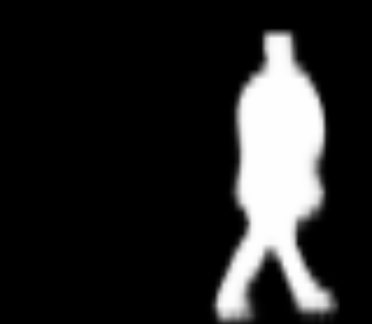

In [10]:
img, _ = test_dataset[0]

model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())